Loaded and validated config from configs/IwDA/TWIC-Net/base.yaml: {'task': 'segmentation', 'model_name': 'FLaTO', 'weights': None, 'transfer_weights': None, 'load_mode': 'best', 'learning_rate': 0.001, 'batch_size': 16, 'num_workers': 4, 'patience': 50, 'delta': 0.005, 'loss': 'ce', 'loss_weights': None, 'num_epochs': 500, 'model_save_dir': './results/IwDA/TWIC-Net', 'metrics': ['mIoU', 'precision', 'recall', 'f1_score'], 'export': False, 'conf_threshold': None, 'save_interval': 5, 'img_size': 224, 'num_classes': 2, 'in_channels': 3, 'datasets': [{'name': 'iw_dataset', 'train_paths': ['datasets/IwDA/train'], 'test_paths': ['datasets/IwDA/test']}]}
Successfully loaded dataset module: iw_dataset


/home/dancher/anaconda3/envs/iw_seg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded custom model 'FLaTO' from 'models/FLaTO.py'.
n_patches: 196, img_size: 14, patch_size: 1
No model found at ./results/IwDA/TWIC-Net/FLaTO_best.pth, starting from scratch.
Model compiled with metrics: ['mIoU', 'precision', 'recall', 'f1_score']
Displaying model predictions on test samples...


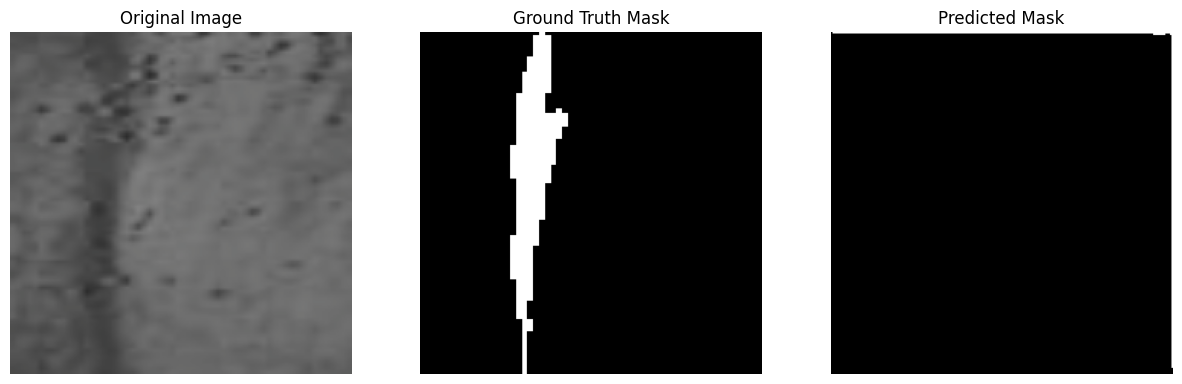

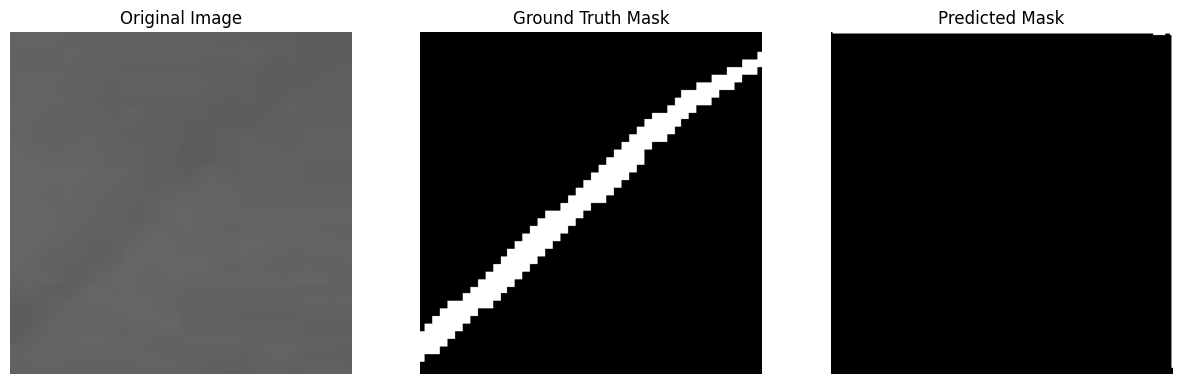

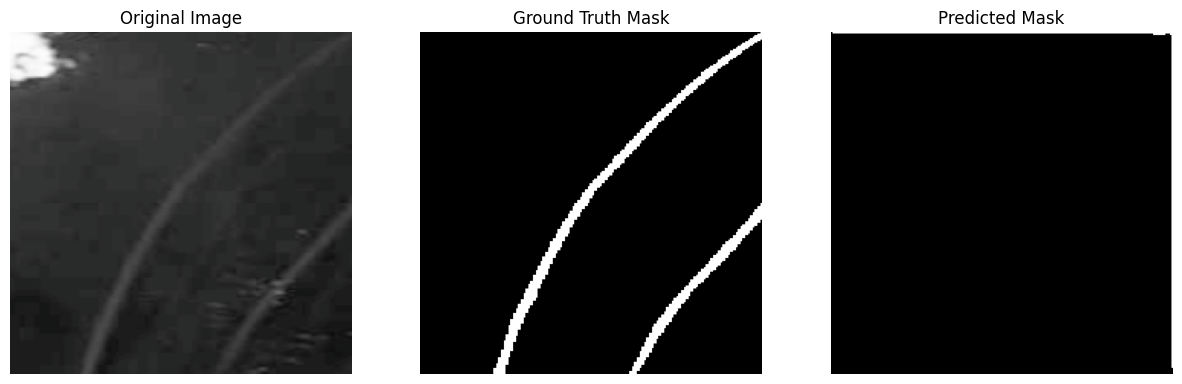

In [ ]:
import torch
import sys
import os
import random
import matplotlib.pyplot as plt
import dancher_tools as dt
import torchvision.transforms as T

module_path = os.path.dirname(os.path.abspath("__file__"))

sys.path.append(module_path)
def display_prediction_samples(test_loader, model, device, num_samples=3):
    """
    随机从数据集中选取样本，用模型预测并展示原图、真实掩码和预测结果。
    """
    model.eval()
    samples = torch.utils.data.Subset(test_loader.dataset, random.sample(range(len(test_loader.dataset)), num_samples))

    with torch.no_grad():
        for image, mask in samples:
            image, mask = image.to(device), mask.to(device)

            # 模型预测
            logits = model(image.unsqueeze(0))  # 添加批次维度
            pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

            # 检查 mask 是否为多通道格式
            if mask.ndim > 2 and mask.shape[0] > 1:
                # 假设掩码为 one-hot 编码，转换为单通道
                mask = torch.argmax(mask, dim=0)
            mask_np = mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式并去除批次维度

            # 确保 mask_np 的形状为 (H, W)
            if mask_np.ndim != 2:
                raise ValueError(f"Mask shape is invalid for visualization: {mask_np.shape}")

            # 反归一化图像
            unnormalize = T.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
            )
            image_np = unnormalize(image).permute(1, 2, 0).cpu().numpy()

            # 绘制图像、真实掩码和预测掩码
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(image_np)
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            axes[1].imshow(mask_np, cmap="gray")
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis("off")

            axes[2].imshow(pred_mask, cmap="gray")
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            plt.show()


def main():
    # 解析参数
    args = dt.utils.get_config('configs/IwDA/TWIC-Net/base.yaml')
    # args.weight = 'results/FLaTO/GK2A_one/FLaTO_best.pth'

    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 获取数据加载器（测试集）
    _, test_loader = dt.utils.get_dataloaders(args)

    # 初始化并加载模型
    model = dt.utils.get_model(args, device)
    model.load(model_dir=args.model_save_dir, mode=args.load_mode, specified_path=args.weights)

    # 定义损失函数
    criterion = dt.utils.get_loss(args)

    # 配置模型
    metrics = dt.utils.get_metrics(args)
    model.compile(optimizer=None, criterion=criterion, metrics=metrics, loss_weights=args.loss_weights)

    # 展示模型预测结果
    print("Displaying model predictions on test samples...")
    display_prediction_samples(test_loader, model, device, num_samples=3)

if __name__ == '__main__':
    main()
